In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Introduction
When insects such as ants leave the nest, for example as they look for food, they can take intricate paths on their scavenging journey. Behavioural experiments have shown that certain species of ants are capable of returning to their starting location in a straight line after roaming around for some time, even in the absence of landmark cues, suggesting that the ant has an internal representation or ‘memory’ of its location which updates based on the movement of the ant (Ziegler et al., 1997; Pisokas and Hennig, 2022).


In this project, we will be implementing a circuit capable of integrating the movement of the ant in two dimensions in order to obtain an estimate of its current position at every time step (Fig. 1). To do this, we will make use of the stability of bump attractors which you will implement yourselves using Poisson neurons. The project starts with some introductory exercises to get acquainted with simulating Poisson neurons and dealing with bump attractors. You will then continue to turn this bump attractor into a network capable of integration, before finally putting everything together at the end and simulating and decoding the trajectory of an agent.


Note: the project is intended to be solved using Python without the need for any specific library (other than the usual numpy and matplotlib). You are free to use other libraries if you want.

## Ex 0. Getting Started: Poisson neurons
In this project, we will be using Poisson neurons to simulate the neural activity. Their simplicity makes them a great candidate for efficiently simulating large scale population dynamics at the cost of some biological inaccuracies. Poisson neurons, as well as rate models in general, are described in more detail in the Neuronal Dynamics book in sections 7.2 and 15.3 respectively.
We use the following model for simulating the neurons. The potential $h_i$ (in mV) of every neuron $i$ evolves according to the differential equation

$$ \tau\frac{dh_{i}}{dt} (t) = −h_{i}(t) + RI_{i}(t)$$

where in the remaining we will take $R = 1M\Omega$. Every neuron has an instantaneous mean firing rate $r_i(t)$ given by the transfer function $g$, for which we will use the sigmoid function

$$r_{i}(t) = r_0g(h_i(t))=r_0\frac{1}{1+e^{-2\alpha(h_i(t)-\beta)}}$$

where $\alpha$ and $\beta$ are parameters for tuning the shape of the transfer function, and $r_0 = 1 ms^{−1}$.
In this model the spikes are generated according to a Poisson process, where the probability of having one spike in an interval $[t, t + \Delta t)$ is


$$P\{\text{spike in }[t,t+\Delta t)\}= r(t)\Delta t$$

**Network parameters.** Unless mentioned otherwise, we will be using the parameters $\alpha = 2$ $mV^{−1}$, $\beta = 0.5 mV$, $\Delta t = 0.1 ms$, $\tau = 10 ms$.
We start by examining the input-output relationship of the Poisson neurons.



**0.1.** Plot the transfer function $g$ as a function of the potential $h$. How do $\alpha$ and $\beta$ affect the shape?

In [2]:
# Define constants in standard units
R = 1e6 # Ohm
r_0 = 1e3 # Hz
alpha = 2e3 # 1/V
beta = 0.5e-3 # V
tau = 10e-3 # s
# Define ransfer function g
def transfer_g(h_i, alpha, beta):
    return 1/(1+np.exp(-2*alpha*(h_i - beta)))

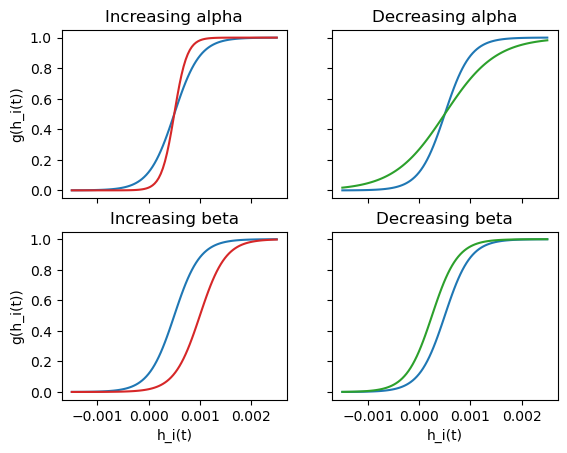

In [3]:
fig, axs = plt.subplots(2, 2)

x = np.linspace(-1.5e-3,2.5e-3, 100)

axs[0, 0].plot(x, transfer_g(x,alpha,beta))
axs[0, 0].plot(x, transfer_g(x,alpha*2,beta), 'tab:red')
axs[0, 0].set_title('Increasing alpha')
axs[0, 1].plot(x, transfer_g(x,alpha,beta))
axs[0, 1].plot(x, transfer_g(x,alpha*0.5,beta), 'tab:green')
axs[0, 1].set_title('Decreasing alpha')
axs[1, 0].plot(x, transfer_g(x,alpha,beta))
axs[1, 0].plot(x, transfer_g(x,alpha,beta*2), 'tab:red')
axs[1, 0].set_title('Increasing beta')
axs[1, 1].plot(x, transfer_g(x,alpha,beta))
axs[1, 1].plot(x, transfer_g(x,alpha,beta/2), 'tab:green')
axs[1, 1].set_title('Decreasing beta')

for ax in axs.flat:
    ax.set(xlabel='h_i(t)', ylabel='g(h_i(t))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

**Question answers:**


Alpha: increasing alpha makes the curve steeper, decreasing alpha makes it less steep.


Beta: horizontal shift, increasing beta shifts the curve to the right, decreasing it shifts it to the left.

**0.2.** Simulate the dynamics of $N = 100$ unconnected neurons for $T = 1000$ ms, receiving the slowly oscillating input $I_i(t) = I_0 sin(\omega t)$ with $I_0 = 2$ nA, $\omega = 10$ rad/s, and with all neurons initialised at $h_i(t=0)=0$ mV .

* Compare the mean number of spikes per ms across the $N$ neurons to the instantaneous rate $r = r_0g(RI(t))$. Explain the difference that you see.
* Now simulate $N = 1000$ neurons. Compare again as before, and explain the difference you see.

**Hints:**

* Write a method that runs the evolution of the membrane potentials, according to Eqs. (1) and (2). It should take as an argument the initial voltages $h_i(t = 0)$, and return all the voltages and spikes of the neurons through time.
* Eq. (1) can be integrated directly using the forward Euler method, with discrete time steps $t = t_0$, $t1$, ... $(t_k = k · \Delta t)$. It gives the following update rule:
  $$h_i(t_{k+1}) = h_i(t_k) + \Delta t · \frac{dh_i}{dt}(t_k)$$
* Combine spikes into bins of size 1ms, and scale accordingly to obtain an average firing rate.

In [3]:
# Define constants in standard units
T = 1 # s
I_0 = 2e-9 # A
omega = 10 # rad/s
delta_t = 1e-4 # s
def I_ex0(t):
    return I_0 * np.sin(omega*t)

def Euler_hi(h_i, delta_t, I, R, tau):
    """
    Euler method for the membrane potential. It gives the value of the membrane potential at the next time step.
    """
    return h_i + (delta_t*(-h_i + R*I)/tau)

In [4]:
def Model0(h0, N, T, delta_t, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate, it's the same for all neurons
            spikes[i,t] = np.random.choice([0,1], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]) # generate spikes
            if t != int(T/delta_t)-1:
                I_i = I_ex0(t)
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage
    return h, spikes, r

In [5]:
def avg_firing_rates(spikes, N, T, delta_t):
    averages = []
    for j in range(int(T/delta_t)):
        averages.append(np.sum(spikes[:, j])/N/delta_t)
    return averages

In [7]:
# Run simultation for 100 neurons
N = 100
h0 = 0
vol_100, spik_100, irate1_100 = Model0(h0,N,T,delta_t, R, tau)

# Run simulation for 1000 neurons
N = 1000
h0 = 0
vol_1000, spik_1000, irate1_1000 = Model0(h0,N,T,delta_t, R, tau)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [03:29<00:00, 47.84it/s]


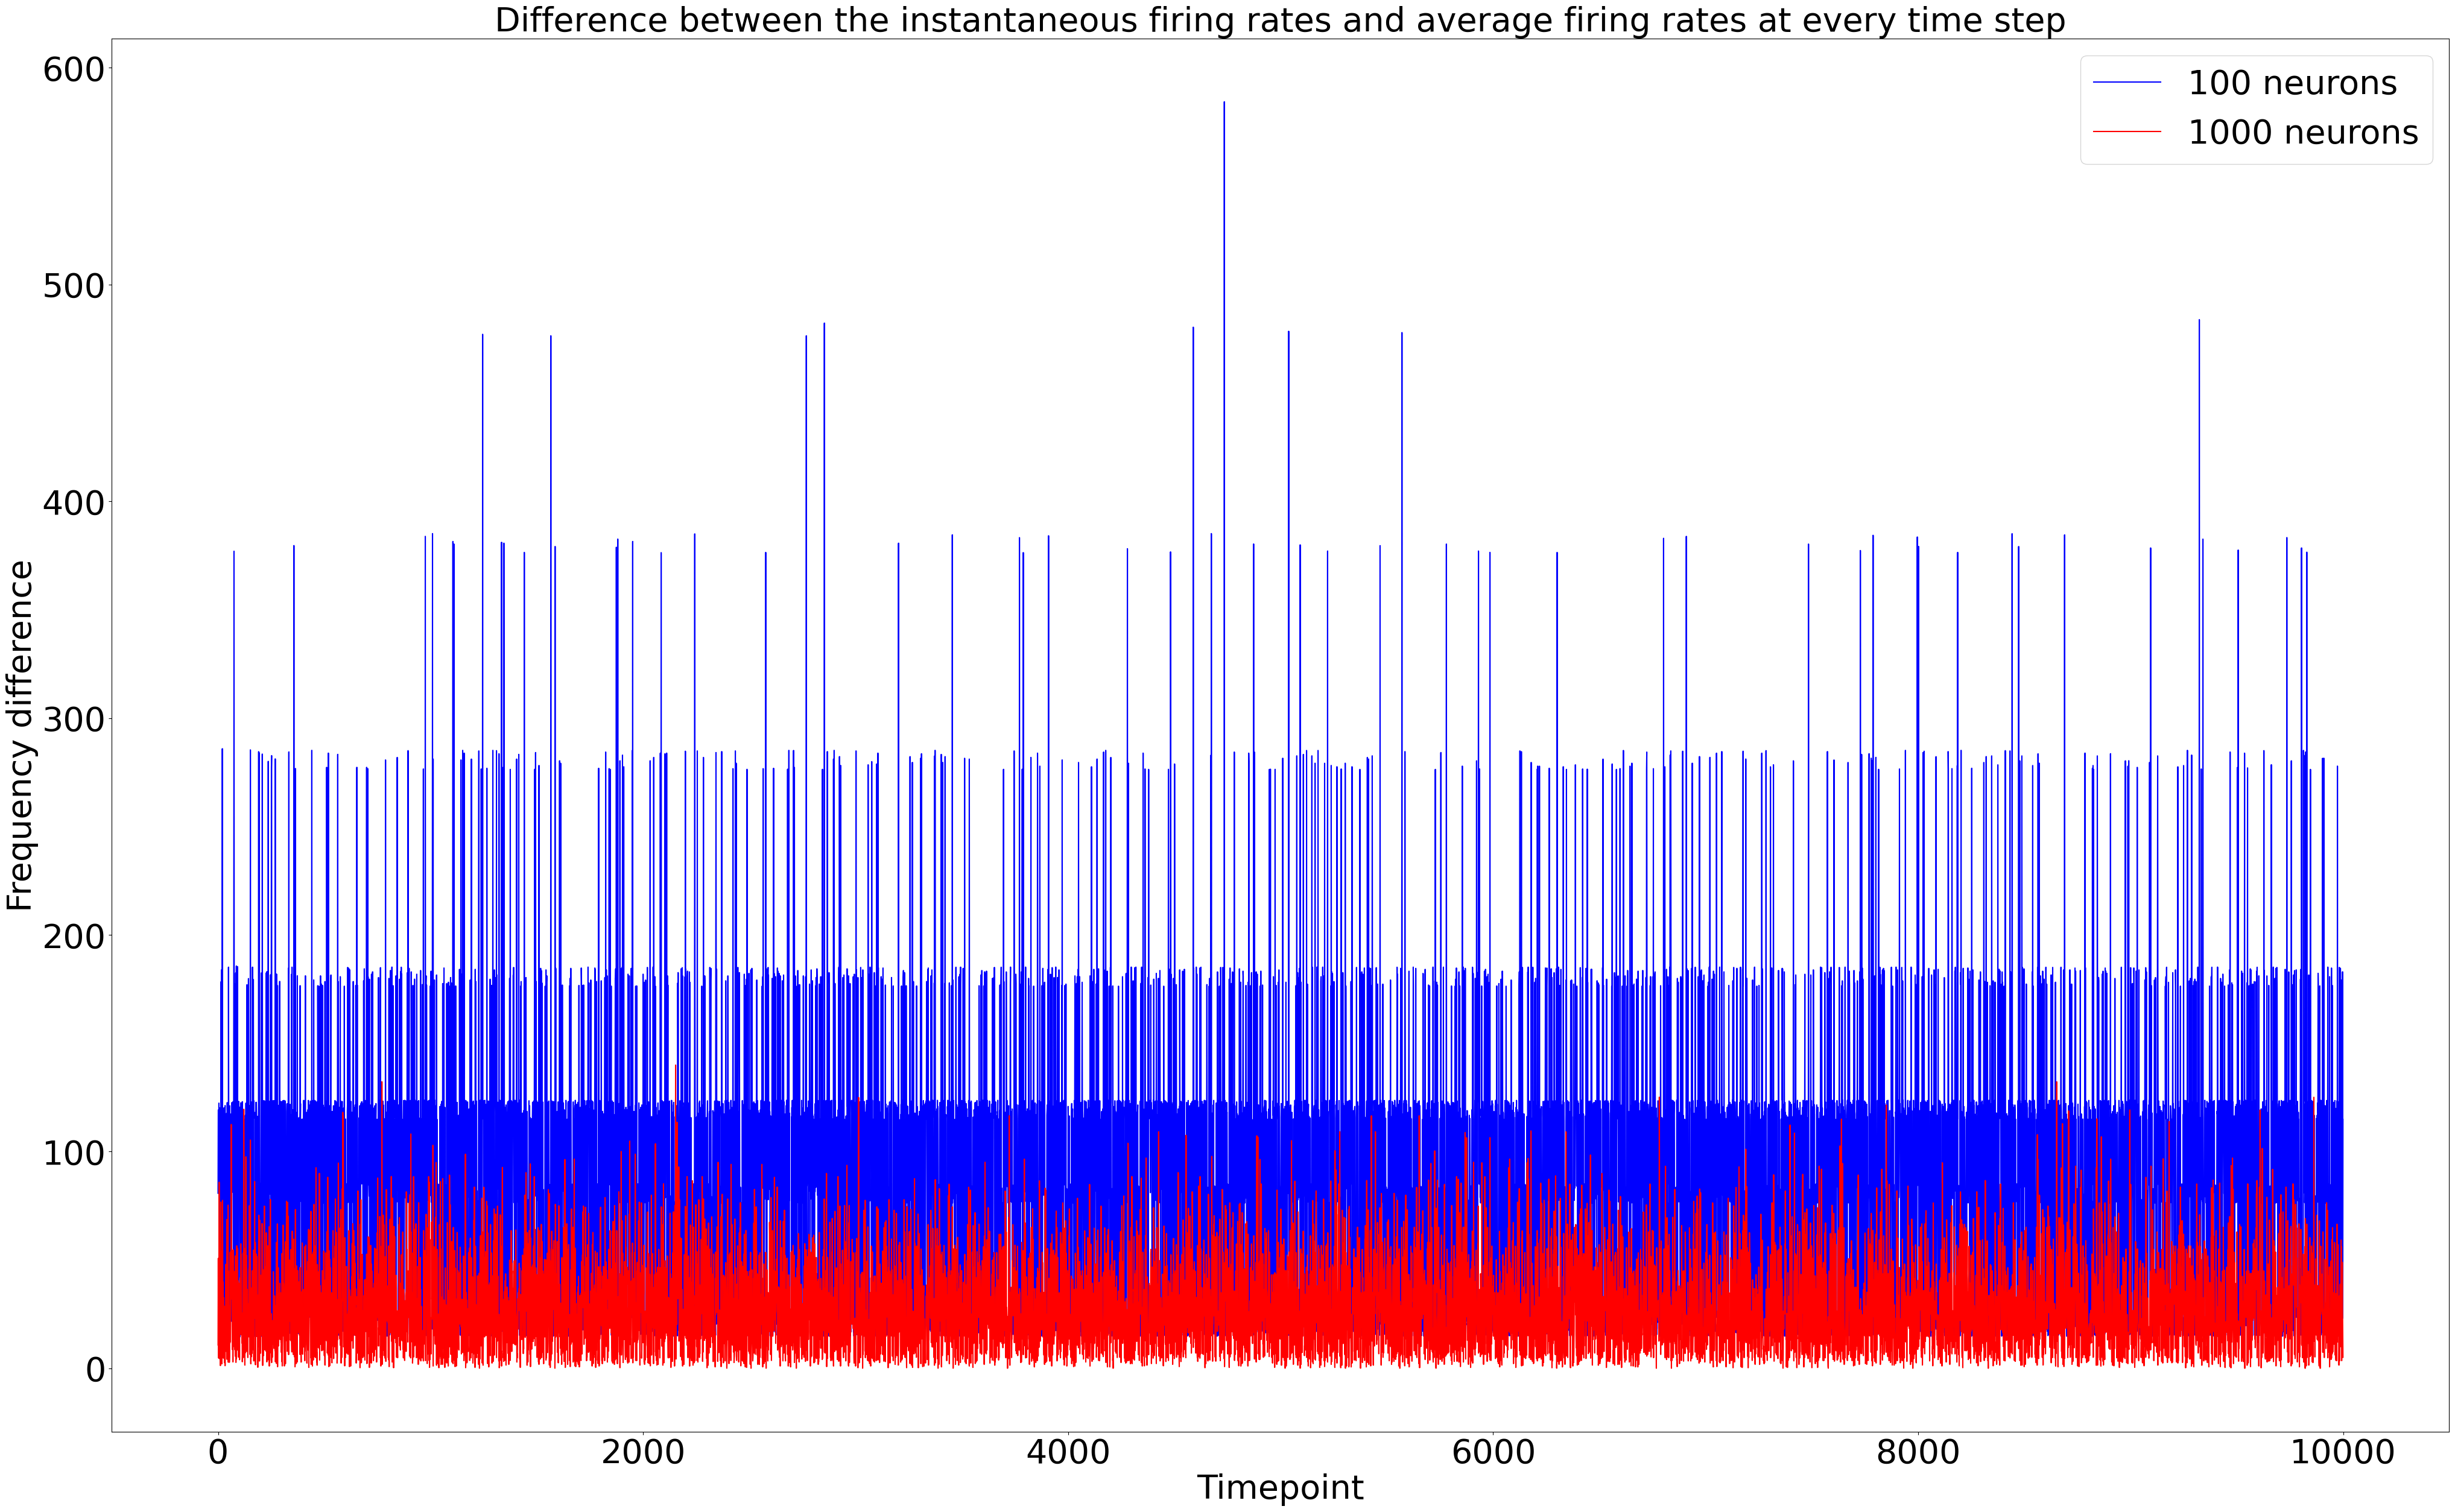

In [9]:
## Plot the difference between the instantaneous rate and the average rate of 100 vs 1000 neurons
plt.figure(figsize=(50,30))
avg_rates_100 = avg_firing_rates(spik_100,100, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_100[0, :] - avg_rates_100), 'b', label = "100 neurons")

avg_rates_1000 = avg_firing_rates(spik_1000,1000, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_1000[0, :] - avg_rates_1000), 'r', label = "1000 neurons")

plt.xlabel("Timepoint", fontsize = 40)
plt.ylabel("Frequency difference", fontsize = 40)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.title("Difference between the instantaneous firing rates and average firing rates at every time step", fontsize=40)

plt.legend(fontsize = 40)
plt.show()

**Question answers:**

When looking at the above plot, we can see that, as expected, the more neurons the closer the average gets to the real value. Indeed, the difference between instantaneous rate and the average number of spikes per ms is due to the fact that the instantaneous rate is a constant, while the average number of spikes per ms is continuous and based on stochastic processes. The more neurons we have, the closer the average number of spikes per ms gets to the instantaneous rate as the number of generated spikes becomes less random.

## Ex 1. Bump attractor

Now that you know how to simulate Poisson neurons, we will use the equations from above to create a recurrent network to implement a bump attractor using $N = 300$ neurons. For this, we assign to each of our $N$ neurons a position $x_i$, equally spaced out over the range [0,2$\pi$). The input to each neuron $i$ is defined through recurrent interactions and an external input, and is given by

$$
I_i(t) = \frac{J}{N} \sum_{j=1}^{N} \omega(x_i,x_j)S_j(t) + I_{ext,i} (t)
$$
$$
\omega(x_i,x_j) = cos(x_i - x_j)
$$

where $J$ (in picoCoulomb; pC) is the interaction strength, and $S_i(t)$ is the spike train of neuron $i$. It can be represented in discrete time as a variable taking value $S_i(t_k) = 1/\Delta t$ if there was a spike of neuron $i$ in time step $k$.


**Decomposition of recurrent weights.** The computational cost of computing the recurrent input as expressed in eq. (6) can be reduced from $\mathcal{O}(N^2)$ to $\mathcal{O}(N)$ by making use of the symmetries of the recurrent weights. The cosine of a difference can be decomposed as
$$
cos(x_i − x_j ) = cos(x_i ) cos(x_j ) + sin(x_i ) sin(x_j )
$$
From this, we can rewrite the recurrent input to each neuron as
$$
\frac{J}{N} \sum_{j=1}^{N}cos(x_i - x_j)S_j(t)=\frac{J}{N} \sum_{j=1}^{N}[cos(x_i ) cos(x_j ) + sin(x_i ) sin(x_j )]S_j(t)
$$
$$
=\frac{J}{N}[cos(x_i)\sum_{j=1}^{N} cos(x_j)S_j(t) + sin(x_i)\sum_{j=1}^{N} sin(x_j)S_j(t)] 
$$

$$=J(cos(x_i)m_{cos}(t) + sin(x_i)m_{sin}(t))$$

with collective variable $m_{cos}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j)S_j(t)$, and similar for $m_{sin}(t)$ (analogous to the overlap variables in the Hopfield model). The computational cost is improved by computing these collective variables only once at each time step.

**1.1** Consider the recurrent network as described above with no external input, and simulate the dynamics. This time, take as initial condition for the potential values sampled from the uniform distribution between 0 and 1: $h_i$(0) ∼ Uniform(0,1) mV. Produce a raster plot of the activity. What values of J
 consistently produce a stable bump in the activity?

In [6]:
def Irecc_ex1(J, mcos, msin, xi):
    """
    Definition of the new equation for I_i(t) in ex.1.
    """
    return J*(mcos*np.cos(xi) + msin*np.sin(xi))

# Define new model for neurons
def Model1_1(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)):
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate at timestep t
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spike for timestep t
                S[i, t] = 1/delta_t # add spike train for timestep t
            if t != n_timesteps-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) # compute the new I_i for timestep t+1
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for timestep t+1
    return h, spikes, r

100%|██████████| 10000/10000 [01:14<00:00, 134.84it/s]


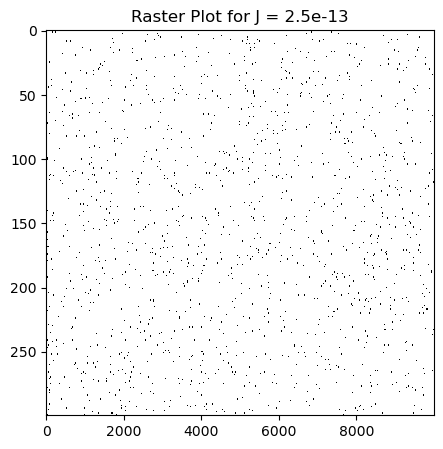

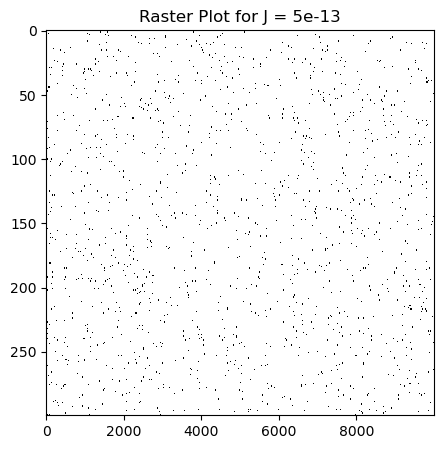

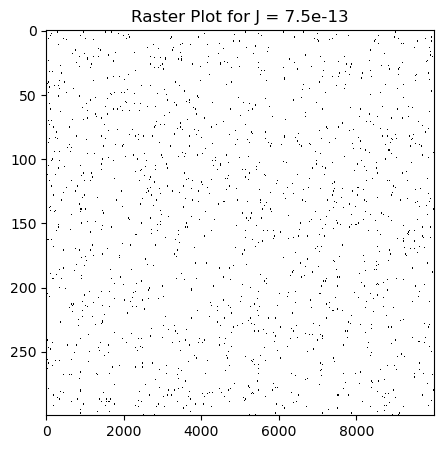

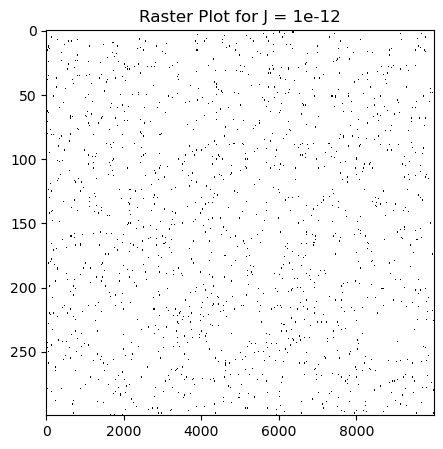

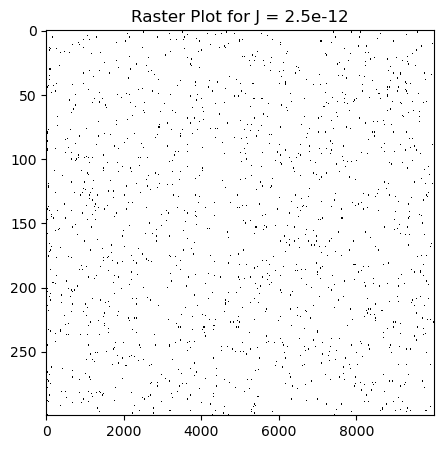

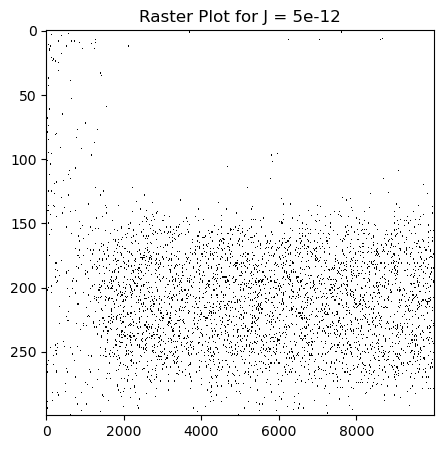

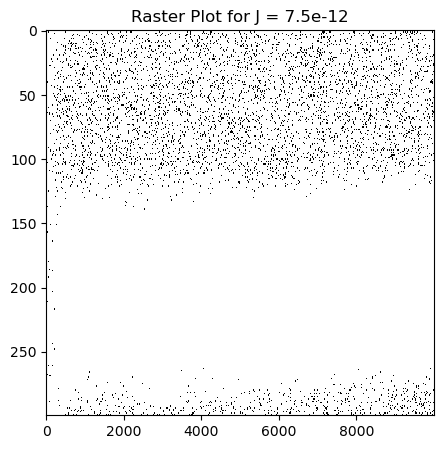

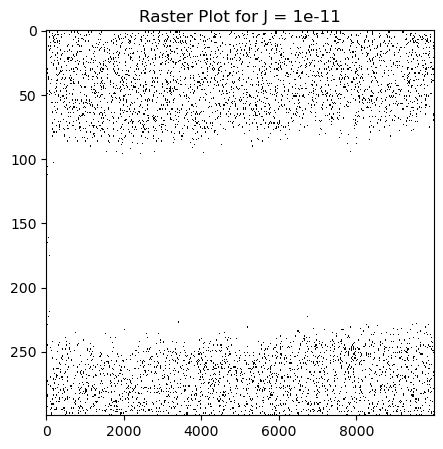

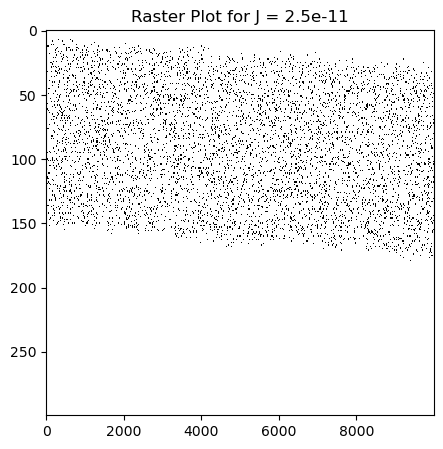

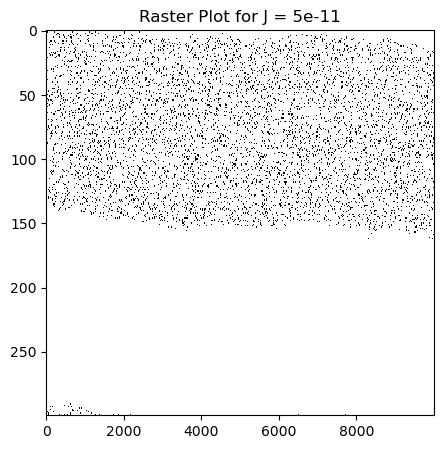

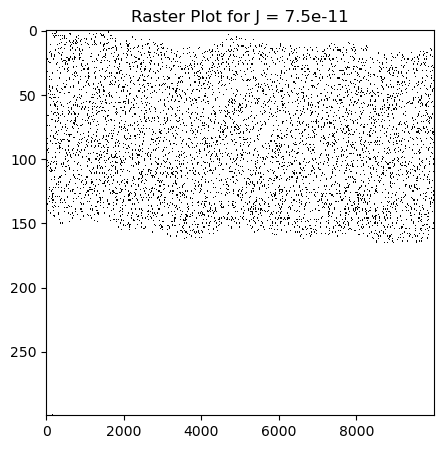

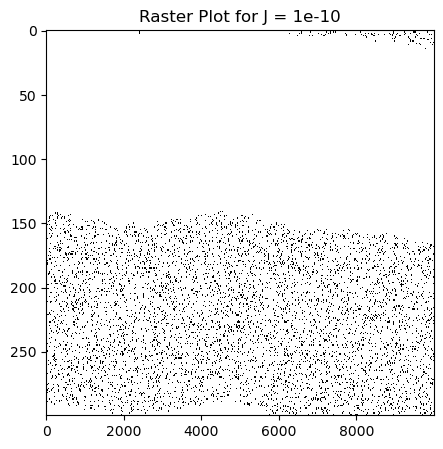

In [39]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3

# Set neuron positions
x = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Define J values to iterate on
Js = np.concatenate([np.linspace(2.5e-13, 1e-12, 4), np.linspace(2.5e-12, 1e-11, 4), np.linspace(2.5e-11, 1e-10, 4)])

# Run the simulations and plot the results
for J in Js:
      h, spikes, r = Model1_1(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)
      plt.figure(figsize=(5,5))
      plt.imshow(spikes, cmap='binary', interpolation='nearest', aspect="auto")
      plt.title(f'Raster Plot for J = {J}')

plt.show()

**Question :** What values of J consistently produce a stable bump in the activity?

**Question answer :** Values of J over 5pC seem to be sufficient for producing a stable bump in the activity.

**1.2.** Implement a function that can decode the location of the bump $θ_{bump}$ over time from the binned activity. How stable is the location of the bump?
**Hints:**
* There are many ways in which this can be done. One approach can be to use a *weighted* version of the circular mean, using what is sometimes referred to as the population vector in neuroscience.
* Stochasticity from the spikes can make it difficult to precisely locate the centre of the bump. Consider using a larger bin size (such as 10ms) for determining the activity.
You should see that the location of the bump, while generally stable, can still move around a bit over larger time scales. This is called drift.


In [80]:
def circular_weighted_mean(spikes, N, T=1, bin_size = 1e-2):
    N = len(spikes)
    xs = np.linspace(0, 2*np.pi, N, endpoint=False)
    number_of_bins = int(T/bin_size)
    weights = np.zeros((N,number_of_bins))
    theta = np.zeros(number_of_bins)
    
    for j in range(number_of_bins): #loop over bins
        for i in range(N): #loop over neurons
            weights[i][j] = (np.mean(spikes[i][(100*j):(100*j)+100]))
        theta[j] = np.arctan2(np.average(np.sin(xs), weights = weights[:,j]), np.average(np.cos(xs), weights = weights[:,j])) 
    return (theta+2*np.pi)%(2*np.pi) # return the angle in the range [0,2pi)

In [11]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3

# Set neuron positions
x = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Define J 
J = 5e-12

# Run the simulations and plot the results
h, spikes, r = Model1_1(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:15<00:00, 133.29it/s]


Text(0.5, 1.0, 'Raster Plot and population vector for J = 5e-12')

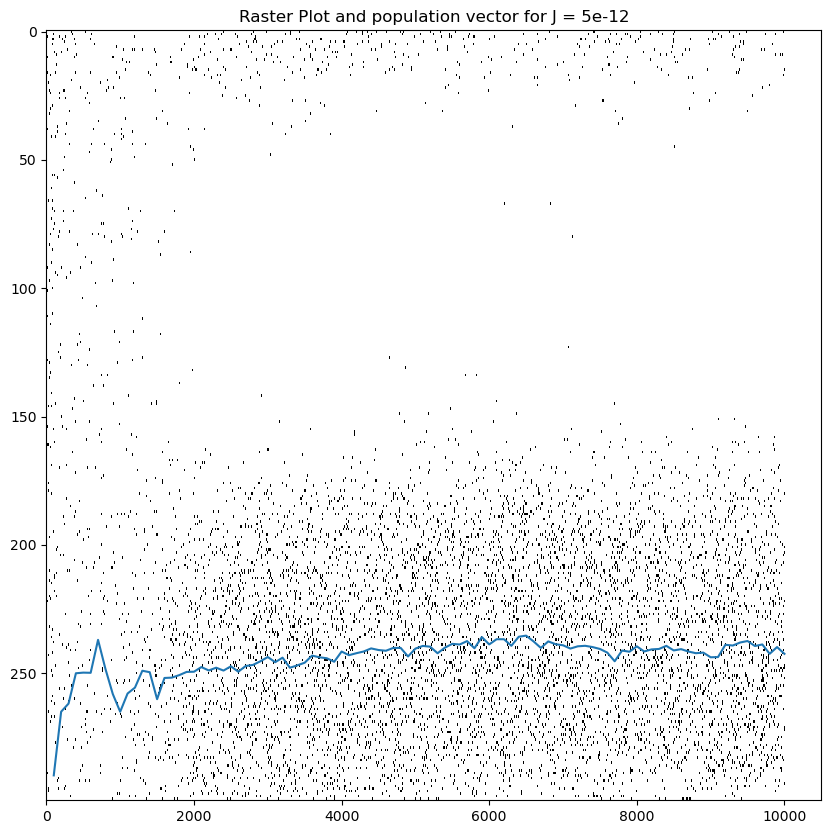

In [81]:
bump1_1 = circular_weighted_mean(spikes, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump1_1)/np.pi*N/2)
plt.title(f'Raster Plot and population vector for J = {J}')

**Question answer:**


The location of the bump drifts a little, but is overall stable.

**1.3.** What causes the location of the bump to drift? In what way can the parameters of the model be modified to improve this?

**Hint** Think about the number of neurons $N$ in your simulation and the integration timescales ($\tau$, $\Delta t$).

**Question answer:**

Several factors could contribute to diminishing the fluctuations. Firstly, we could increase the number of neurons. As we've seen in the previous exercise, the more neurons we have, the more stable the overall population activity, and this again applies here.

Second, we could also increase the membrane time constant. Indeed, the larger the time constant, the more stable the activity of the neurons (due to the longer time required for things to change), and thus the more stable the bump.

**1.4.** Simulate the network with the external input described above, and create a rasterplot of the spikes. What is the effect of the input on the bump? How can this behaviour be explained by looking at the connectivity profile ?

In [37]:
# Define a function for the external current
def Iext_ex1(t, xi, T, delta_t):
    sigma = np.pi/8
    if t < 0.4*T/delta_t and t >= 0.3*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 2*np.pi/3)**2)/(2*sigma**2))
    elif t < 0.7*T/delta_t and t >= 0.6*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 4*np.pi/3)**2)/(2*sigma**2))
    else:
        return 0
    
# Define a model for question 1.4
def Model1_4(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) + Iext_ex1(t, xs[i], T, delta_t) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [38]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12
R = 1e6
tau = 10e-3

# Compute initial voltages
h0 = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_1_4, spikes_1_4, r_1_4 = Model1_4(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)

100%|██████████| 10000/10000 [01:23<00:00, 119.11it/s]


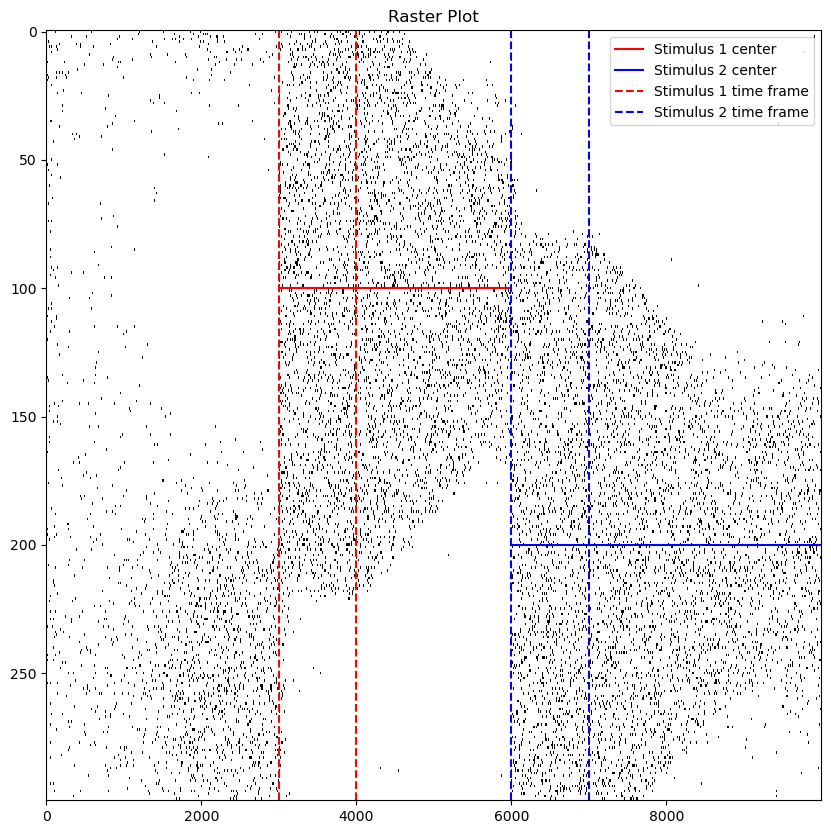

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(spikes_1_4, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(range(3000, 6000, 10), np.repeat(N/3, (6000-3000)/10), color = 'r', label = "Stimulus 1 center")
plt.plot(range(6000, 10000, 10), np.repeat(N/3, (10000-6000)/10)*2, color = 'b', label = "Stimulus 2 center")
plt.axvline(x = 3000, color = 'r', linestyle='--', label = "Stimulus 1 time frame") 
plt.axvline(x = 4000, color = 'r', linestyle='--')
plt.axvline(x = 6000, color = 'b', linestyle='--', label = "Stimulus 2 time frame") 
plt.axvline(x = 7000, color = 'b', linestyle='--')
plt.title('Raster Plot')
plt.legend()
plt.show()

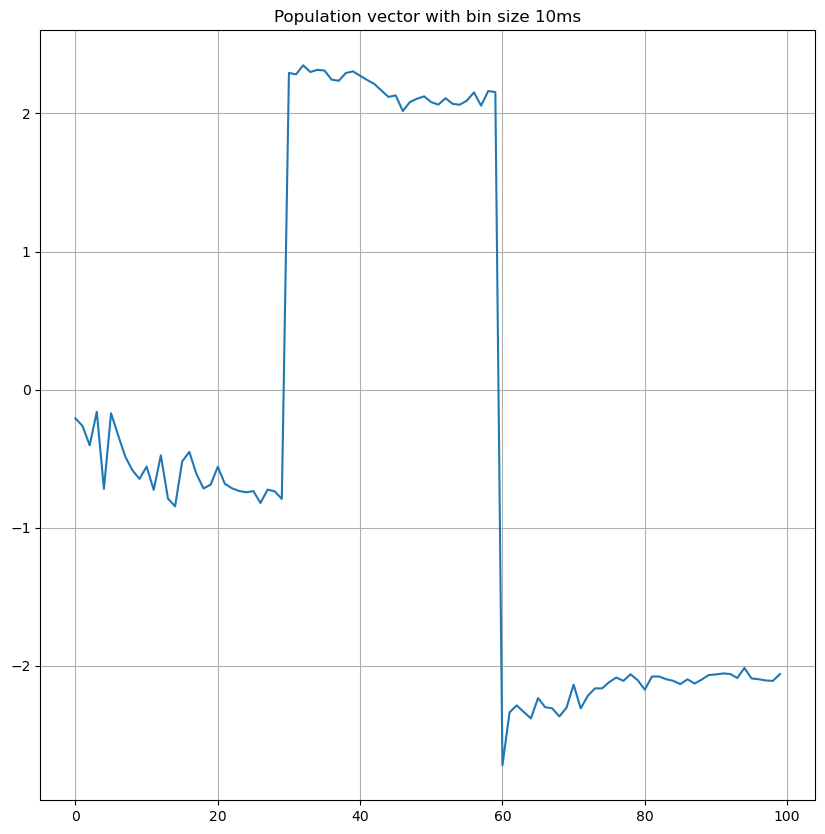

In [35]:
plt.figure(figsize=(10,10))
plt.plot(circular_weighted_mean(spikes_1_4, N))
plt.title('Population vector with bin size 10ms')
plt.grid()

**Question answer:**


We can see from the above rasterplot that the external input shifts the bump to a particular location. This is easily explained by the connectivity profile, which given by the cosine of the difference in position of the neurons, meaning that the closer the angles of two neurons are, the higher their connectivity. On its own, this connectivity profile makes sure that neurons that are activated form a group and inhibit the neurons that are further away. Adding the external input, which is strongest around some neurons' positions and much stronger than the natural input to the neurons, shifts the activity bump around the predetermined positions.


**1.5.** In the case without external input, what would happen to the bump if the connectivity was instead given by $w(x_i − \phi,x_j)$, with $\phi$ a small angle? Explain the behaviour you would expect, and verify it through a simulation.

**Hint** This recurrent connectivity can again be implemented using the collective variables $m_{cos}$ and $m_{sin}$ from before, but with slightly different terms in front.

**Question answer:**

Adding an offset to the circuit weights would make the bump drift over time in a certain direction. Indeed, this offset will make neurons activate most strongly neurons that are at a distance (angle) $\phi$ away from them, which will in turn do the same.

In [63]:
# Define the new recurrent connectivity 
def Irecc_ex1_5(J, mcos, msin, xi, phi):
    """
    Definition of the new equation for I_i(t) in ex.1_5.
    """
    return J*(mcos*np.cos(xi-phi) + msin*np.sin(xi-phi))
    
# Define a model for question 1.5
def Model1_5(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau, phi):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1_5(J, mcos, msin, xs[i], phi) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [64]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12
R = 1e6
tau = 10e-3
phi = np.pi/100

# Compute initial voltages
h0 = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_1_5, spikes_1_5, r_1_5 = Model1_5(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau, phi)

100%|██████████| 10000/10000 [01:11<00:00, 140.33it/s]


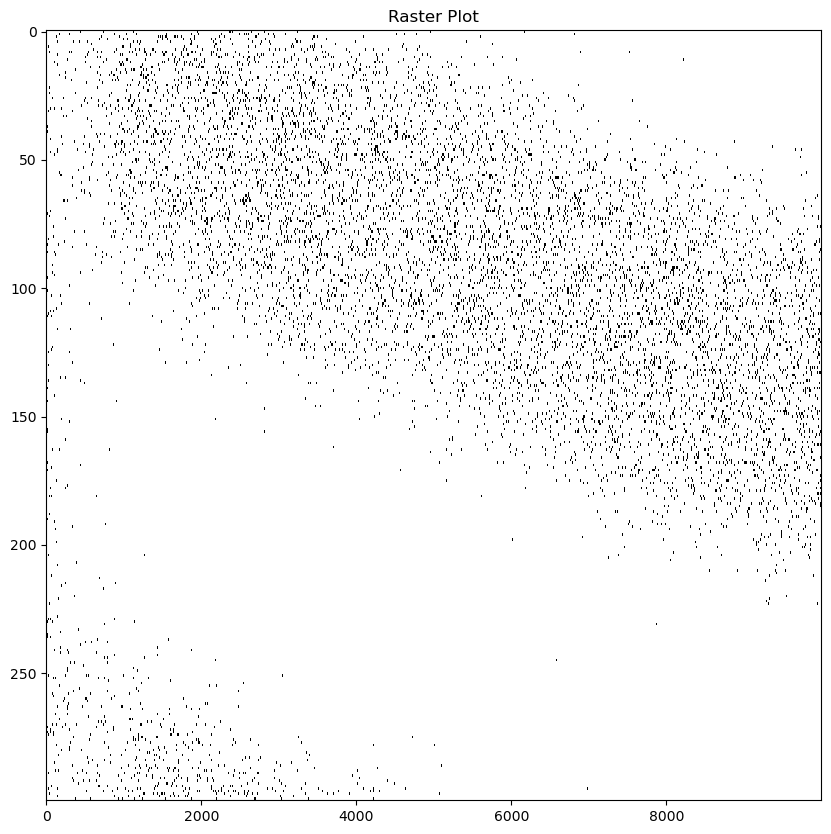

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(spikes_1_5, cmap='binary', interpolation='nearest', aspect="auto")
plt.title('Raster Plot')
plt.show()

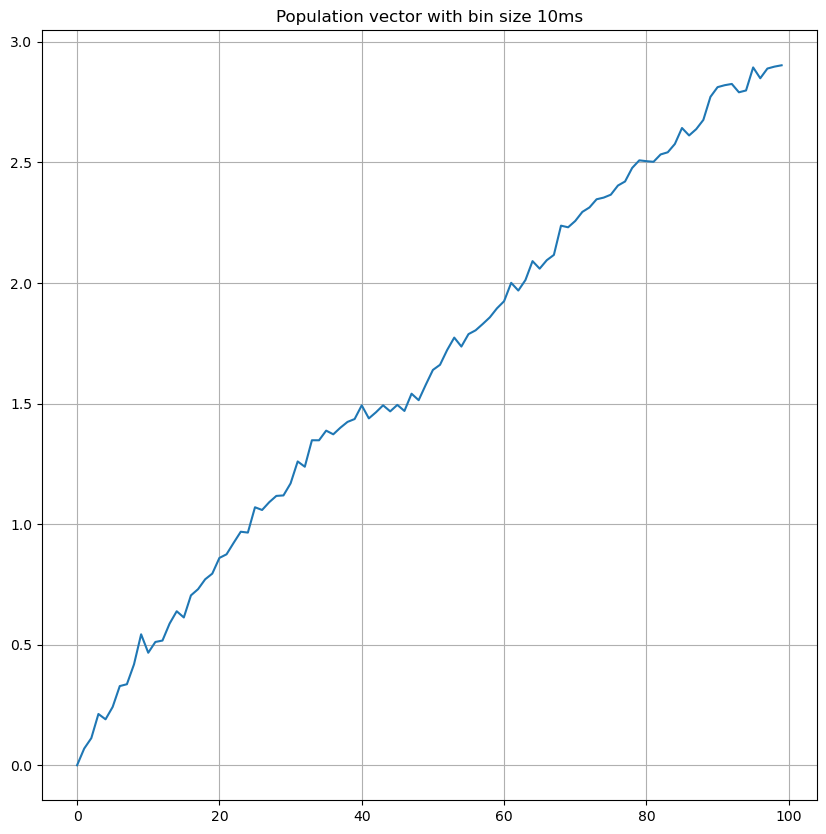

In [66]:
plt.figure(figsize=(10,10))
plt.plot(circular_weighted_mean(spikes_1_5, N))
plt.title('Population vector with bin size 10ms')
plt.grid()

Text(0.5, 1.0, 'Raster Plot and population vector for J = 5e-12')

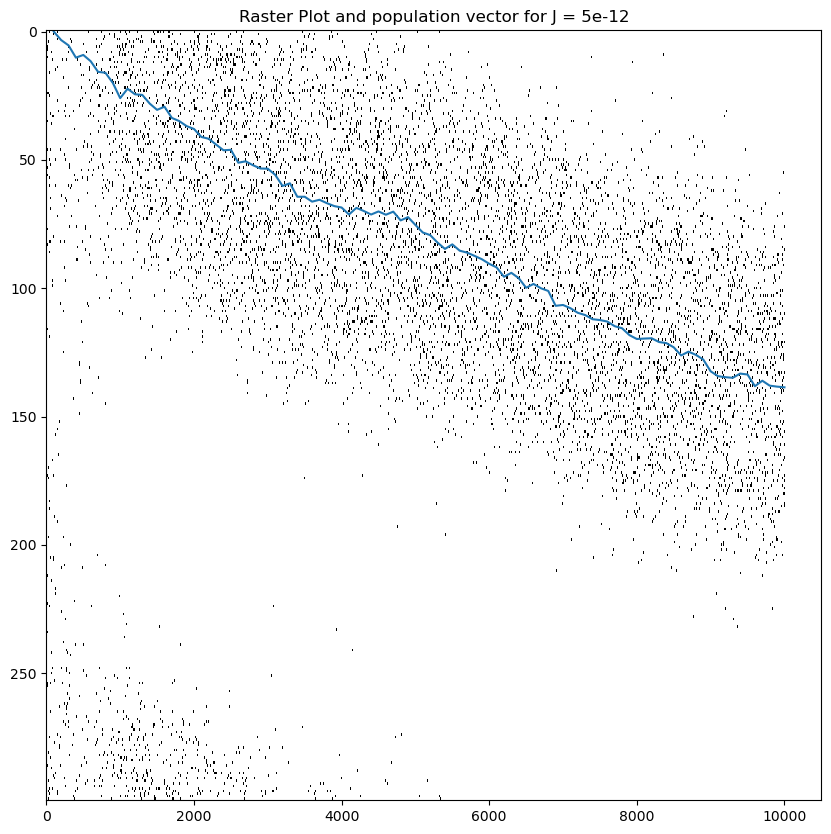

In [90]:
bump1_5 = circular_weighted_mean(spikes_1_5, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes_1_5, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump1_5)/np.pi*N/2)
plt.title(f'Raster Plot and population vector for J = {J}')

Our simulation shows what we expected.

## Ex 2. Integration
In this second part, we will combine two offset bump attractors together to form a circuit capable of integrating a variable. For this, we make two copies of the circuit from above which we will call the left (L) and the right (R) population, with circuit weights
$$
\omega_{L\rightarrow L}(x_i^L,x_j^L) = cos(x_i^L + \theta -x_j^L)
$$
$$
\omega_{R\rightarrow R}(x_i^R,x_j^R) = cos(x_i^R - \theta -x_j^R)
$$
$$
\omega_{R\rightarrow L}(x_i^R,x_j^L) = cos(x_i^R - \theta -x_j^L)
$$
$$
\omega_{L\rightarrow R}(x_i^L,x_j^R) = cos(x_i^L + \theta -x_j^R)
$$

where $x^L$ and $x^R$ denote the locations of the neurons in the left and right population respectively, and where $\theta$ denotes some offset in the weights between the two populations. For each population, again take $N = 300$ neurons equally spread out over the interval $[0, 2\pi)$.
The stable configuration of this system is depicted in Figure 2. The two bumps can be shifted to the left or to the right by globally stimulating the left or right population respectively. 

**2.1.** Write down the equation of the full input received for each neuron in both of the populations, in terms of four collective variables. Without simulating the network, explain how this connectivity can be considered a “push-pull system” in the stable configuration.

**Hint** For this, illustrate the connectivity between the two populations by depicting only the locations of peak excitation. Specifically, consider the angle at which the most active neurons in each population most excite other neurons, both in the same population as well as in the other population. Also consider what will happen if you globally excite or inhibit one of the two populations.

The input to each neuron $i$ in each population is given by

$$
I_i^L(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow L}(x_i^L,x_j^L)S_j^L(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow L}(x_i^L,x_j^R)S_j^R(t) + I_{ext,i}^L (t)
$$
$$
 = J[cos(x_i^L+ \theta )(m^L_{cos}(t)+m^R_{cos}(t)) + sin(x_i^L+ \theta )(m^L_{sin}(t)+m^R_{sin}(t))]
$$
$$
I_i^R(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow R}(x_i^R,x_j^R)S_j^R(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow R}(x_i^R,x_j^L)S_j^L(t) + I_{ext,i}^R (t)
$$
$$
 = J[cos(x_i^R- \theta )(m^L_{cos}(t)+m^R_{cos}(t)) + sin(x_i^R- \theta )(m^L_{sin}(t)+m^R_{sin}(t))]
$$

with collective variables:
$$m_{cos}^L(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^L)S_j^L(t)$$
$$m_{sin}^L(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^L)S_j^L(t)$$
$$m_{cos}^R(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^R)S_j^R(t)$$
$$m_{sin}^R(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^R)S_j^R(t)$$





**Question answer:**

Neurons in the L population will be most excited by neurons that are -$\theta$ away from them, both in the L and R populations. While neurons in the R population will be most excited by neurons that are $\theta$ away from them, both in the L and R populations. Therefore, as both populations are actually exciting each other, but from a distance, it makes sense for it to be called a "push-pull system".

**2.2.** Test the stability of the combined circuit. For this, use $\theta$ = 10°, $J$ = 3 pC, and randomly initialised potentials $h_i(0)$ ∼ Uniform(0,1) mV. Plot the location of the two bumps $\theta _{bump\space L/R}$ over time. How stable is this configuration?

In [51]:
# Define the new recurrent connectivity 
def IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xi, theta):
    """
    Definition of the new equation for I_iL(t) in ex.2_2.
    """
    return J*((mcosL+mcosR)*np.cos(xi+theta) + (msinL+msinR)*np.sin(xi+theta))
    
def IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xi, theta):
    """
    Definition of the new equation for I_iR(t) in ex.2_2.
    """
    return J*((mcosL+mcosR)*np.cos(xi-theta) + (msinL+msinR)*np.sin(xi-theta))
    
# Define a model for question 2.2
def Model2_2(h0_L, h0_R, xs_L, xs_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta):
    n_timesteps = int(T/delta_t)
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_L = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_L = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_R = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_R = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_R[:,0] = h0_R
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*S_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*S_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*S_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*S_R[:, t-1])
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r_L[i,t]*delta_t),r_L[i,t]*delta_t]): # generate spikes
                spikes_L[i,t] = 1 # add spikes
                S_L[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_R[i,t]*delta_t),r_R[i,t]*delta_t]): # generate spikes
                spikes_R[i,t] = 1 # add spikes
                S_R[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta) # compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta) # compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
    return h_L, spikes_L, r_L, h_R, spikes_R, r_R

In [52]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0_L = np.random.uniform(0, 1e-3, N)
h0_R = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_L_2_2, spikes_L_2_2, r_L_2_2, h_R_2_2, spikes_R_2_2, r_R_2_2 = Model2_2(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta)


100%|██████████| 10000/10000 [02:30<00:00, 66.62it/s]


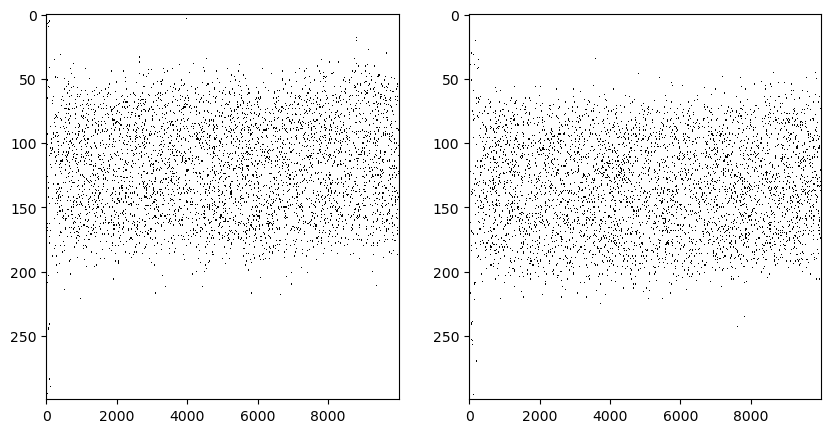

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(spikes_L_2_2, cmap='binary', interpolation='nearest', aspect="auto")
ax2.imshow(spikes_R_2_2, cmap='binary', interpolation='nearest', aspect="auto")

plt.show()

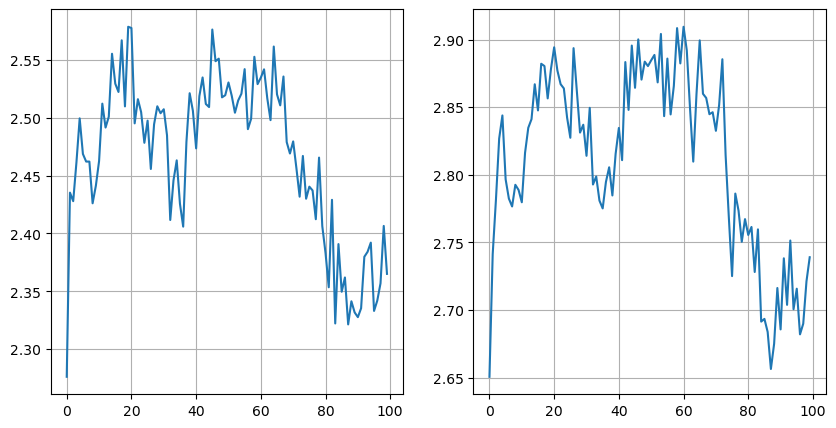

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(circular_weighted_mean(spikes_L_2_2, N))
ax2.plot(circular_weighted_mean(spikes_R_2_2, N))
ax1.grid()
ax2.grid()

Text(0.5, 0.98, 'Raster plots and population vectors')

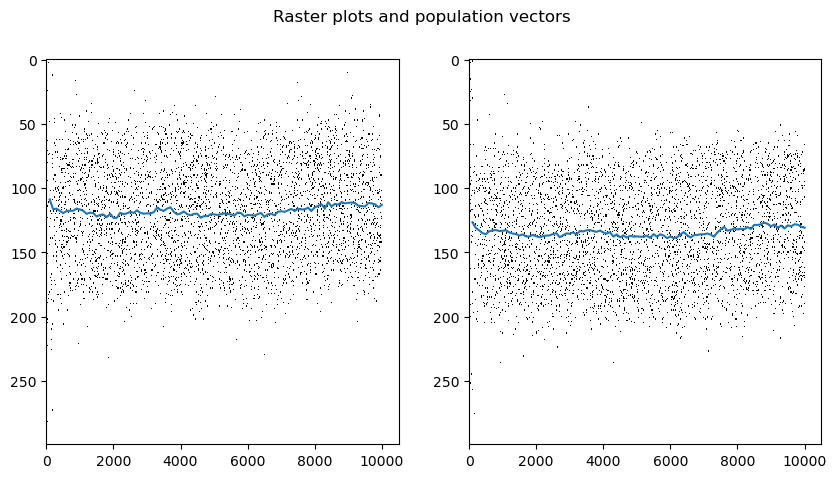

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
bumpL_2_2 = circular_weighted_mean(spikes_L_2_2, N)
ax1.imshow(spikes_L_2_2, cmap='binary', interpolation='nearest', aspect="auto")
ax1.plot(np.arange(100, 10100, 100), (bumpL_2_2/np.pi*N/2))
bumpR_2_2 = circular_weighted_mean(spikes_R_2_2, N)
ax2.imshow(spikes_R_2_2, cmap='binary', interpolation='nearest', aspect="auto")
ax2.plot(np.arange(100, 10100, 100), (bumpR_2_2/np.pi*N/2))
plt.suptitle(f'Raster plots and population vectors')

**Question answer:** The bump location already seems much more stable than before !


Next, we will test the integrating capabilities of the circuit. This will be used later to decode the ant’s position from the location of the bump.


**2.3.** Find a way to initialise the potential $h_i(t = 0)$ such that the mean location of the two bumps is at $\theta_{bump\space mean} ≈ \pi$. This will be helpful later on for decoding the displacement.

In [100]:
surrounding = 10 # how many neurons around pi???
h_i = np.zeros(N)
h_i[int(N/2) - int(surrounding/2):int(N/2) + int(surrounding/2)] = 1e-3

**2.4.** Take $I_0$ as varying from -1.5 to 1.5 nA in 51 steps. Simulate the dynamics and plot the final location $\theta _{bump \space mean}$ as a function of the input strength $I_0$. What would be a good upper limit on the input strength such that the relation between $I_0$ and the final bump location is linear?


**Hint** Consider using rate neurons to find more accurate values.

In [105]:
# Define the external current
def IextL_ex2_4(t, I_0, T, delta_t):
    if t < 0.6*T/delta_t and t >= 0.3*T/delta_t:
        return I_0
    else:
        return 0
    
def IextR_ex2_4(t, I_0, T, delta_t):
    if t < 0.6*T/delta_t and t >= 0.3*T/delta_t:
        return -I_0
    else:
        return 0
    
# Define a model for question 2.4
def Model2_4(h0_L, h0_R, xs_L, xs_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, I_0):
    n_timesteps = int(T/delta_t)
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_L = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_L = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_R = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_R = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_R[:,0] = h0_R
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*S_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*S_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*S_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*S_R[:, t-1])
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r_L[i,t]*delta_t),r_L[i,t]*delta_t]): # generate spikes
                spikes_L[i,t] = 1 # add spikes
                S_L[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_R[i,t]*delta_t),r_R[i,t]*delta_t]): # generate spikes
                spikes_R[i,t] = 1 # add spikes
                S_R[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta) + IextL_ex2_4(t, I_0, T, delta_t)# compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta) + IextR_ex2_4(t, I_0, T, delta_t)# compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
    return h_L, spikes_L, r_L, h_R, spikes_R, r_R

# Define a model for question 2.4
def Model2_4_v2(h0_L, h0_R, xs_L, xs_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, I_0):
    n_timesteps = int(T/delta_t)
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    S_L = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    S_R = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_R[:,0] = h0_R
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*S_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*S_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*S_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*S_R[:, t-1])
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            S_L[i, t] = r_L[i,t] # add spike train
            S_R[i, t] = r_R[i,t] # add spike train
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta) + IextL_ex2_4(t, I_0, T, delta_t)# compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta) + IextR_ex2_4(t, I_0, T, delta_t)# compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
    return h_L, r_L, h_R, r_R

def circular_weighted_mean_v2(rates, N, T=1, bin_size = 1e-2):
    N = len(spikes)
    xs = np.linspace(0, 2*np.pi, N, endpoint=False)
    number_of_bins = int(T/bin_size)
    theta = np.zeros(number_of_bins)
    
    for j in range(number_of_bins): #loop over bins
        theta[j] = np.arctan2(np.average(np.sin(xs), weights = rates[:,j]), np.average(np.cos(xs), weights = rates[:,j])) 
    return (theta+2*np.pi)%(2*np.pi) # return the angle in the range [0,2pi)

In [111]:
# Define parameters
N = 300
T = 0.1 # reduced so the running of the cell doesn't take too long
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

# Set neuron positions
x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Set initial voltages
h0_L = np.random.uniform(0, 1e-3, N)
h0_R = np.random.uniform(0, 1e-3, N)

# Set interval for I_0s
I_0s = np.linspace(-1.5e-9, 1.5e-9, 51)

# Run simulations and get mean of final bump locations
final_bump_locs = []
for i0 in I_0s:
      h_L_2_4, spikes_L_2_4, r_L_2_4, h_R_2_4, spikes_R_2_4, r_R_2_4 = Model2_4(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, i0)
      thetas_L = circular_weighted_mean(spikes_L_2_4, x_L, T, 1e-2, delta_t)
      thetas_R = circular_weighted_mean(spikes_R_2_4, x_R, T, 1e-2, delta_t)
      final_bump_locs.append((thetas_L[-1] + thetas_R[-1])/2)

  0%|          | 0/51 [00:14<?, ?it/s]


TypeError: circular_weighted_mean() takes from 2 to 4 positional arguments but 5 were given

In [112]:
# Define parameters
N = 300
T = 0.1 # reduced so the running of the cell doesn't take too long
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

# Set neuron positions
x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Set initial voltages
h0_L = np.random.uniform(0, 1e-3, N)
h0_R = np.random.uniform(0, 1e-3, N)

# Set interval for I_0s
I_0s = np.linspace(-1.5e-9, 1.5e-9, 51)

# Run simulations and get mean of final bump locations
final_bump_locs = []
for i0 in tqdm(I_0s):
      h_L_2_4, r_L_2_4, h_R_2_4, r_R_2_4 = Model2_4_v2(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, i0)
      thetas_L = circular_weighted_mean_v2(r_L_2_4, x_L, T, 1e-2)
      thetas_R = circular_weighted_mean_v2(r_R_2_4, x_R, T, 1e-2)
      final_bump_locs.append((thetas_L[-1] + thetas_R[-1])/2)

100%|██████████| 51/51 [02:53<00:00,  3.40s/it]


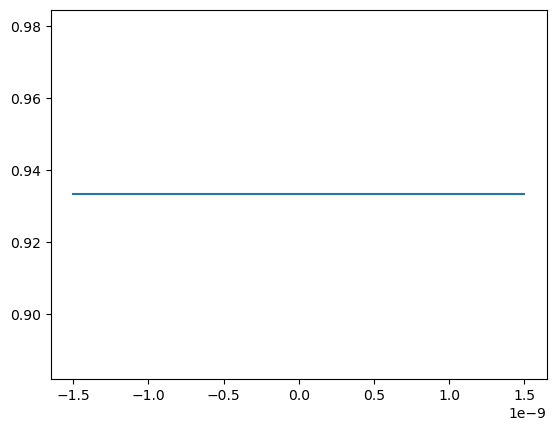

In [113]:
plt.plot(I_0s, final_bump_locs)

**2.5.** Explain how this system of coupled bump attractors can be seen as a system for integration of the input.

# TODO answer question

**Question answer:**